# Comparison with CEBRA

This notebook compares the decoding performance of MARBLE with CEBRA on a macaque centre-out reaching task. 

To make this notebook run, you'll need to install cebra. Follow instructions here: https://cebra.ai/docs/installation.html


In [3]:
#!pip install statannotations

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.pyplot as plt
from run_marble import fit_pca, load_data, format_data
from cebra import CEBRA
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from statannotations.Annotator import Annotator
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from spiking_analysis_helpers import *
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's train a CEBRA model first 

Load firing rate data

In [5]:
data_file = "data/rate_data_20ms.pkl"
metadata_file = "data/trial_ids.pkl"
    
rates, trial_ids = load_data(data_file, metadata_file)

File ‘data/rate_data_20ms.pkl’ already there; not retrieving.
File ‘data/trial_ids.pkl’ already there; not retrieving.


In [6]:
#session = 0 # pick a session id [0:44]
#pca_n = 5
#filter_data = True
#conditions = ["DownLeft", "Left", "UpLeft", "Up", "UpRight", "Right", "DownRight"]

#pca = fit_pca(rates, session, conditions, filter_data=filter_data, pca_n=pca_n)
#pos, vel, timepoints, condition_labels, trial_indexes = format_data(rates, 
#                                                                    trial_ids,
#                                                                    session, 
#                                                                    conditions, 
#                                                                    pca=pca,
#                                                                    filter_data=filter_data)

#define model
#cebra_model = CEBRA(model_architecture='offset10-model',
#                        batch_size=512,
#                        learning_rate=0.0001,
#                        temperature=1,
#                        output_dimension=3,
#                        max_iterations=5000,
#                        distance='euclidean',
#                        conditional='time_delta',
#                        device='cuda_if_available',
#                        verbose=True,
#                        time_offsets=10)

#pos_all = np.vstack(pos)
#condition_labels = np.hstack(condition_labels)
#cebra_model.fit(pos_all, condition_labels)
#cebra_pos = cebra_model.transform(pos_all)

#fig = plt.figure(figsize=(4, 2), dpi=300)
#ax = plt.subplot(121, projection='3d')
#x = ax.scatter(cebra_pos[:, 0],
#               cebra_pos[:, 1],
#               cebra_pos[:, 2],
#               c=condition_labels,
#               cmap=plt.cm.hsv,
#               s=0.01)
#ax.axis('off')
#plt.show()

# Load MARBLE and CEBRA embeddings

In [12]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7062022 -O data/marble_embeddings_20ms_out20.pkl
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7509031 -O data/marble_embeddings_20ms_out20.pkl
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6969885 -O data/kinematics.pkl

with open('data/marble_embeddings_20ms_out20.pkl', 'rb') as handle:
    _, marble_embeddings, _, _, trial_ids, _  = pickle.load(handle)

with open('data/cebra_embeddings_20ms_out20.pkl', 'rb') as handle:
    _, cebra_embeddings, _, _, _, _ = pickle.load(handle)

# load kinematic data
data = pickle.load(open('data/kinematics.pkl','rb'))       

# define conditions of movement
conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  

File ‘data/marble_embeddings_20ms_out20.pkl’ already there; not retrieving.
File ‘data/kinematics.pkl’ already there; not retrieving.


In [13]:
# use the saved trial ids to match the embeddings to the kinematics

for d in list(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    for t in unique_trial_ids:
        data[d][t]['lfads_factors'] = data[d][t]['lfads_factors'][:,:-1]
        data[d][t]['marble_emb'] = marble_embeddings[d][trial_ids[d]==t,:].T
        data[d][t]['cebra_emb'] = cebra_embeddings[d][trial_ids[d]==t,:].T

# Decoding single session


### Optimal linear decoding via LFADS, MARBLE and CEBRA

In [9]:
session = 0

unique_trial_ids = np.unique(trial_ids[session])

L_lfads = train_OLE(data[session], trial_ids[session], representation='lfads_factors')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_lfads, alpha=1, dt=20, representation='lfads_factors')
    data[session][tr]['lfads_decoded'] = trial_pred
    
L_marble = train_OLE(data[session], trial_ids[session], representation='marble_emb')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_marble, alpha=1, dt=20, representation='marble_emb')
    data[session][tr]['marble_decoded'] = trial_pred
    
L_cebra = train_OLE(data[session], trial_ids[session], representation='cebra_emb')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_cebra, alpha=1, dt=20, representation='cebra_emb')
    data[session][tr]['cebra_decoded'] = trial_pred

### Comparison of decoding with ground truth

Text(0.5, 1.0, 'CEBRA')

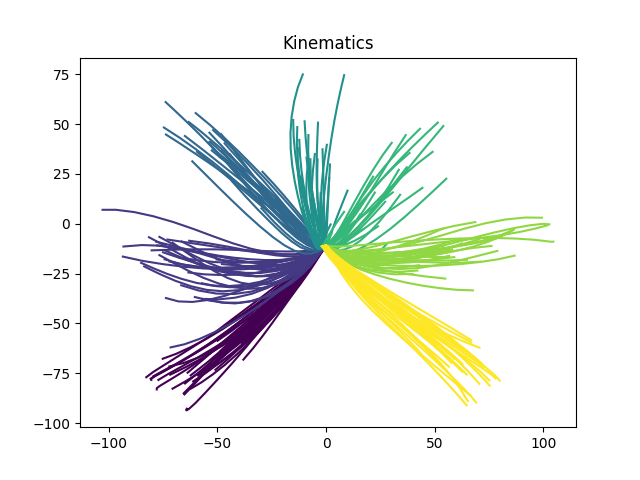

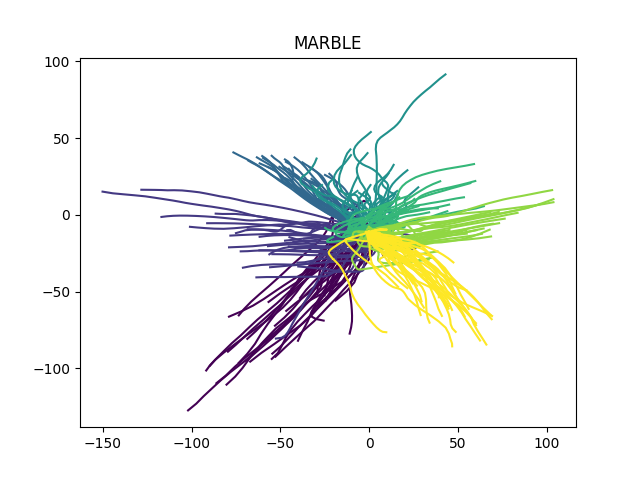

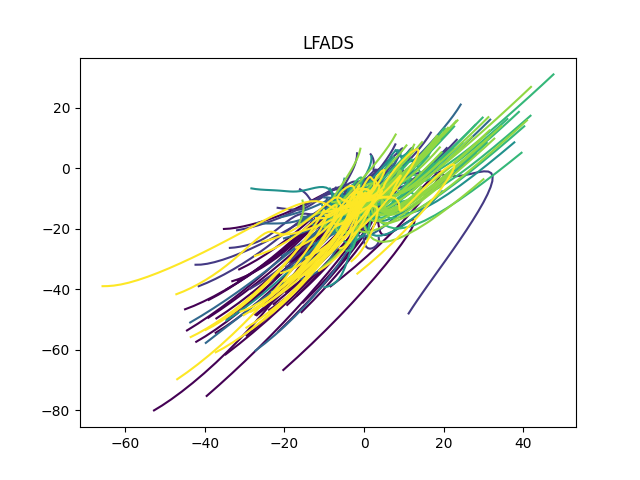

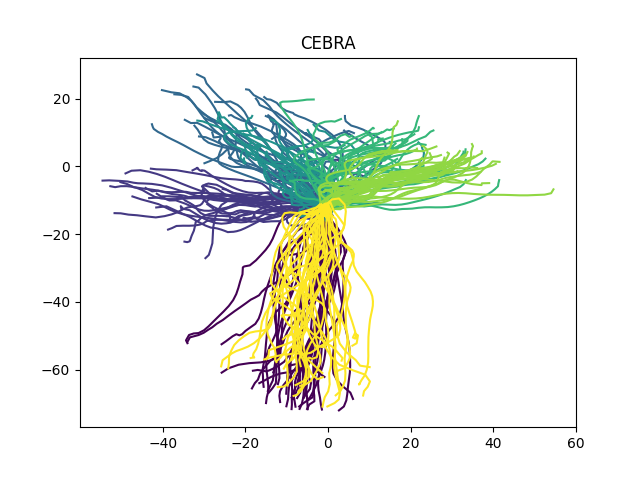

In [10]:
colors = plt.cm.viridis(np.linspace(0,1,7))         
plt.figure()
for c,cond in enumerate(conditions):   
    for t in unique_trial_ids:
        if data[session][t]['condition']==cond:
            meh = data[session][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('Kinematics')

plt.figure()
for c,cond in enumerate(conditions):   
    for t in unique_trial_ids:
        if data[session][t]['condition']==cond:
            meh = data[session][t]['marble_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('MARBLE')
            
            
plt.figure()
for c,cond in enumerate(conditions):   
    for t in unique_trial_ids:
        if data[session][t]['condition']==cond:
            meh = data[session][t]['lfads_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('LFADS')

plt.figure()
for c,cond in enumerate(conditions):   
    for t in unique_trial_ids:
        if data[session][t]['condition']==cond:
            meh = data[session][t]['cebra_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('CEBRA')

# Decode across all sessions

Above we decoded for a single session. Lets now loop over every session and compute some quantitative comparisons with the ground truth kinematics.

In [14]:
kf = KFold(n_splits=5, shuffle=True) # use 5-fold split of the data 

r2_lfads_vel = []; r2_lfads_pos = []

# loop over seessions
for d in tqdm(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(unique_trial_ids)):

        train_data = {key: data[d][key] for key in train_index if key in data[d]}

        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='lfads_factors')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, alpha=1, dt=20, representation='lfads_factors')
            data[d][tr]['lfads_decoded'] = trial_pred
            
    # r-squared velocity
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='lfads_decoded')   
    r2_lfads_pos.append(r2_pos)
    r2_lfads_vel.append(r2_vel)

100%|███████████████████████████████████████████| 44/44 [00:22<00:00,  1.99it/s]


Lets now decode for cebra embeddings at every session

In [15]:
kf = KFold(n_splits=5, shuffle=True) # use 5-fold split of the data 

r2_cebra_vel = []; r2_cebra_pos = []

# loop over seessions
for d in tqdm(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(unique_trial_ids)):

        train_data = {key: data[d][key] for key in train_index if key in data[d]}

        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='cebra_emb')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, alpha=1, dt=20, representation='cebra_emb')
            data[d][tr]['cebra_decoded'] = trial_pred
            
    # r-squared velocity
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='cebra_decoded')   
    r2_cebra_pos.append(r2_pos)
    r2_cebra_vel.append(r2_vel)

100%|███████████████████████████████████████████| 44/44 [00:22<00:00,  2.00it/s]


Lets now decode for MARBLE embeddings at every session.

In [16]:
r2_marble_vel = []; r2_marble_pos = []

# loop over seessions
for d in tqdm(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(unique_trial_ids)):

        train_data = {key: data[d][key] for key in train_index if key in data[d]}

        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='marble_emb')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, alpha=1, dt=20, representation='marble_emb')
            data[d][tr]['marble_decoded'] = trial_pred
            
    # r-squared velocity
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='marble_decoded')   
    r2_marble_pos.append(r2_pos)
    r2_marble_vel.append(r2_vel)

100%|███████████████████████████████████████████| 44/44 [00:23<00:00,  1.90it/s]


Lets now visualise the decoded kinematics for the same set of example sessions (Fig S7).

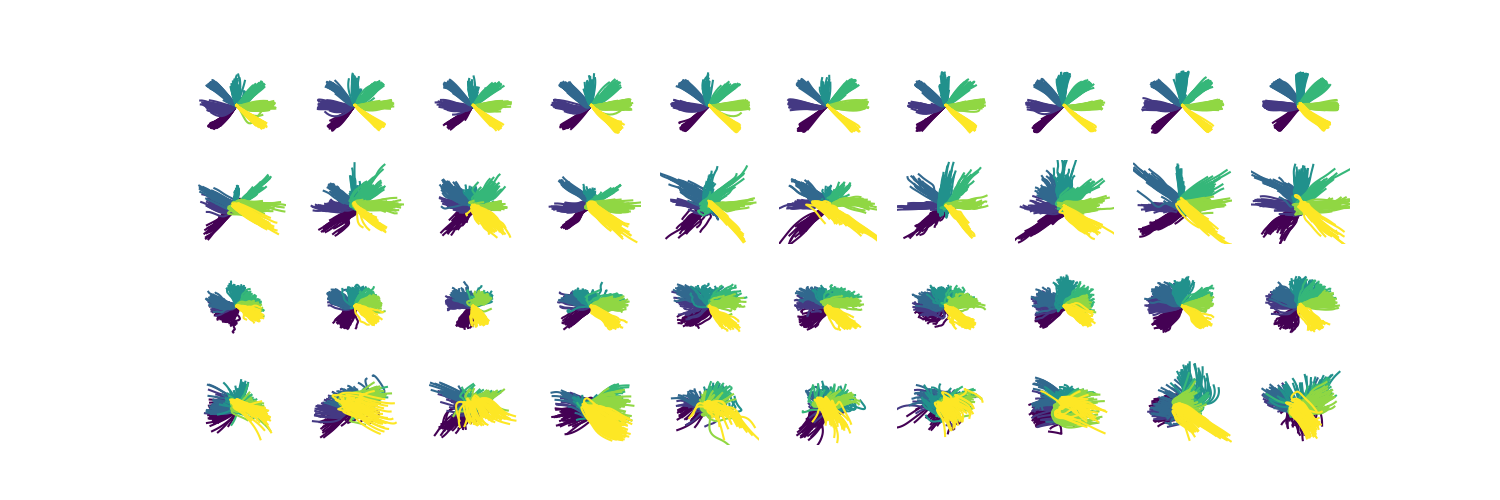

In [19]:
# chosen example sessions
examples = [5,6,8,11,14,15,18,23,26,32]

fig, ax = plt.subplots(4,len(examples),figsize=(15,5))

for i,d in enumerate(examples):
    
    sz = 140

    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                meh = data[d][t]['kinematics']
                ax[0,i].plot(meh[0,:],meh[1,:],c=colors[c])

    ax[0,i].set_xlim([-sz, sz])
    ax[0,i].set_ylim([-sz, sz])
    ax[0,i].set_axis_off()

    unique_trial_ids = np.array(list(dict.fromkeys(trial_ids[d].tolist())))

    #MARBLE
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                meh = data[d][t]['marble_decoded']
                ax[1,i].plot(meh[0,:],meh[1,:],c=colors[c])
    ax[1,i].set_xlim([-sz, sz])
    ax[1,i].set_ylim([-sz, sz])
    ax[1,i].set_axis_off()  
    
    #CEBRA
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                meh = data[d][t]['cebra_decoded']
                ax[2,i].plot(meh[0,:],meh[1,:],c=colors[c])
    ax[2,i].set_xlim([-sz, sz])
    ax[2,i].set_ylim([-sz, sz])
    ax[2,i].set_axis_off() 
    
    #LFADS
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                meh = data[d][t]['lfads_decoded']
                ax[3,i].plot(meh[0,:],meh[1,:],c=colors[c])
    ax[3,i].set_xlim([-sz, sz])
    ax[3,i].set_ylim([-sz, sz])
    ax[3,i].set_axis_off()  

How does the decoding accuracy of velocity between the two methods compare?

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

marble vs. CEBRA: Wilcoxon test (paired samples), P_val:1.137e-13 Stat=0.000e+00
marble vs. LFADS: Wilcoxon test (paired samples), P_val:1.033e-03 Stat=2.210e+02


(<Axes: xlabel='model', ylabel='accuracy'>,
  <statannotations.Annotation.Annotation at 0x7efc858cffa0>])

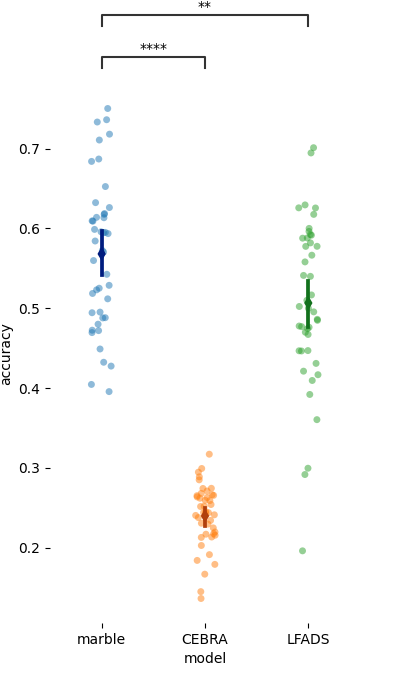

In [20]:
results = pd.DataFrame(data=np.vstack([ r2_marble_vel, r2_cebra_vel, r2_lfads_vel]).T,columns=['marble', 'CEBRA', 'LFADS'])
results = results.melt()
results.columns = ['model','accuracy']

f, ax = plt.subplots(figsize=(4,7))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)

sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

pairs=[("LFADS", "marble"), ("CEBRA","marble")]

annotator = Annotator(ax, pairs, data=results, x="model", y="accuracy",)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()

We can also train a classifier to predict the movement? This tells us about the accuracy of decoding the position vectors.

In [24]:
kinematic_model_acc = []
marble_model_acc = []
cebra_model_acc = []
lfads_model_acc = []

for d in tqdm(data.keys()):           

    # fit classifier to kinematics
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                sample = data[d][t]['kinematics'][:2,:-1].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    clf = SVC().fit(X, y)
    kinematic_model_acc.append(clf.score(X, y))
    
    # evaluate model on marble decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                sample = data[d][t]['marble_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    marble_model_acc.append(clf.score(X, y))
    
    # evaluate model on cebra decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                sample = data[d][t]['cebra_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    cebra_model_acc.append(clf.score(X, y))
    
    # evaluate model on lfads decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in data[d].keys():
            if data[d][t]['condition']==cond:
                sample = data[d][t]['lfads_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    lfads_model_acc.append(clf.score(X, y))

results = pd.DataFrame(data=np.vstack([ marble_model_acc, cebra_model_acc, lfads_model_acc]).T,columns=['marble', 'cebra', 'LFADS'])

results = results.melt()
results.columns = ['model','accuracy']

100%|███████████████████████████████████████████| 44/44 [00:01<00:00, 37.28it/s]


<Axes: xlabel='model', ylabel='accuracy'>

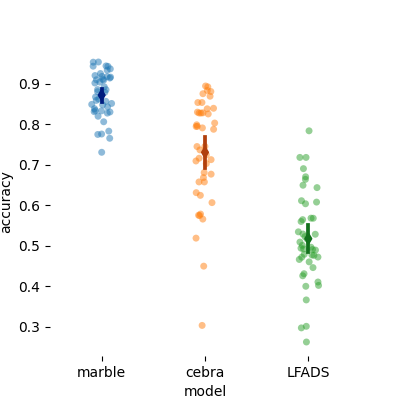

In [25]:
f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)


sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)